# Full Correlational Matrix Analysis (FCMA) demo 

### Purpose of this notebook
- Given an experimental deisgn that consists two conditions (A and B), we can ask whether the functional connectivities between brain regions differ across conditions A and B. Traditional FC analyses will leverage a seed based FC analysis, which may be biased (seeds are aribtrary selected) and miss potential important regions (Wang et al., 2015). In order to perform whole-brain FC analyses in a non-seed based manner, FCMA was developed. 

- Using FCMA, we can answer 1) Do functional connectivity patterns differ across condition A and B and 2) what are the brain regions among which the FC pattern defines a task condition. 

- This jupyter notebook uses simulated data to demo how the above two questions could be answered with FCMA.


## Important features of simualted data
- Knowing these will help understand FCMA preprocessing step of the features selection and classification. 


- The simulated data consists of 8 subjects. The experiment was **block designed**, and consists of condition A and B. **Each condition has 10 blocks, thus 20 blocks** in total for a subject. The orders of the blocks were randomized across the 8 subjects. Each **block (i.e., epoch) lasts 15 seconds** followed by **5 seconds of ISI**. The total exepriment lasts 400 seconds in total. **TR = 1 second**. 


- To reduce computational demands, we randomly selected 400 voxels as the brain mask. Thus the simulated data only has **400 brain voxels**, each voxel has 400 TRs.  



In [1]:
from brainiak.fcma.preprocessing import prepare_fcma_data
from brainiak.fcma.preprocessing import RandomType
from brainiak.fcma.classifier import Classifier
from brainiak import io
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import sys
from mpi4py import MPI
import logging
import numpy as np
import pandas as pd
import nibabel as nib
import os, glob, subprocess
from itertools import product
import seaborn as sns
from nilearn import image, plotting

## FCMA Step1: Feature (voxel) selection
### The goal: 
- Given the specified "left_out_subj", we devided the 8-subjects data into a training set (7 subjects) and a testing set (1 subject). This is refered as the "outer loop leave-one-out cross validation". The goal here is to perform feature selection on the traning set and use selected features to build a predicted model and tested using the testing set. 

In [2]:
# --------------------
# Set up directories
# --------------------

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'simulated_data')  # What is the directory containing data?
suffix = '.nii.gz'  # What is the extension of the data you're loading
mask_file = os.path.join(cur_dir, 'cherry_picked_brain',  'cherry_pick_brain_mask.nii.gz')  # What is the path to the whole brain mask
epoch_file = os.path.join(cur_dir, 'simulated_data', 'sim_epoch_file.npy')  # What is the path to the epoch file
left_out_subj = 0  # Which participant (as an integer) are you leaving out for this cv, for the current demo, set it to 0
output_dir = os.path.join(cur_dir, 'FCMA_result')  # What is the path to the folder you want to save this data in

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# ----------------------------
# load and Preprocess the data
# ----------------------------

print("Load in the volumes, mask and labels")
images = io.load_images_from_dir(data_dir, suffix=suffix)
mask = io.load_boolean_mask(mask_file)
epoch_list = io.load_labels(epoch_file)

print("Parse the epoch data for useful dimensions")
epochs_per_subj = epoch_list[0].shape[1]
num_subjs = len(epoch_list)

print("Preprocess the data and prepare for FCMA")
raw_data, _, labels = prepare_fcma_data(images, epoch_list, mask)

# ----------------------------------
# Outer loop - take out traning set 
# for feature selection
# ----------------------------------

print("enforce left one out")
start_idx = int(int(left_out_subj) * epochs_per_subj)
end_idx = int(start_idx + epochs_per_subj)

print("Take out the idxs corresponding to all participants but this one")
subsampled_idx = list(set(range(len(labels))) - set(range(start_idx, end_idx)))
labels_subsampled = [labels[i] for i in subsampled_idx]
raw_data_subsampled = [raw_data[i] for i in subsampled_idx]

Load in the volumes, mask and labels
Parse the epoch data for useful dimensions
Preprocess the data and prepare for FCMA
enforce left one out
Take out the idxs corresponding to all participants but this one


### Understand preprocessed data
- Up to this point, we have our tarining set ready, which includes all epochs (i.e., blocks) and lables for all subjects except subject-0. Now let's look at our training set in more details. 
- Remember that each subject has 20 epochs (i.e., blocks), evenly divided into two conditions. Given that we have 7 subjects' data in our outer-loop traning set, we have in total 7 x 20 = 140 epochs, thus 140 labels. 
- Each epoch is a two-dimension array of TR by voxel. In the simulated data, each epoch lasts 15 TRs (TR = 1 sec) and the cherry picked brain has in total 400 voxels. Thus each epoch array has the shape of 15 by 400. 

In [3]:
print(f"Label count: {len(labels_subsampled)}")
print(f"Epoch (block) count: {len(raw_data_subsampled)}")
print(f"Shape of each epoch (block): {raw_data_subsampled[0].shape}")

Label count: 140
Epoch (block) count: 140
Shape of each epoch (block): (15, 400)


### Feature selection with simplified implementation
- Please note that the following code chunk is an extremely primitive version of FCMA feature selection and is not practical for real data due to computation limits. The actual FCMA codes ultilized the message passing interface (MPI) which requests at least 2 processors for a job. Because jupyter notebook typically only allow for 1 processor, the actualy FCMA code cannot be used for this demo. However, this primitive version is designed to be a conceptual implementation of the feature selection step for FCMA and can be used to understand what exactly happens under the hood

#### Steps:

1. First, we enlarge the feature space by computing the correltaion matrix of all voxels in the barin. Becuase the simulated brain only has 400 voxels, this yields a 400 x 400 correlation matrix. Each row/column is the functional connectivity between a given voxel and all other voxels in the brain. (Note that this is extemely not efficient computational wise and this was done using the kernel trick (the precomputed kernel) in the acutal FCMA implementation.)

2. For each barin voxel, we want to know how well does its functional connectivity with every other brain voxels can be used to characterize the task conditions. Thus, for each brain voxel, we can 
    - A) Extract the correpsonding row from each subject's correlation matrix, resulting a single array for each subject.  
    - B) Perform the inner loop leave-one-out cross validation. For each fold, 7-1 = 6 arrays (one for each subjects) will be used as the training set and the left array will be used as the validation set. 
    - C) A prediction accuracy value for this selected voxel could be computed for each fold, 
    - D) Final prediction accuracy for this voxel could be averaged across the 7 folds. 

    - It seems computationally managable here because the simulated data only has 400 voxels. The actual FCMA code ultilized MPI for parallel computation, so multiple voxels could be dealt with at the same time

In [74]:
# -----------------------------
# Enlargeing the feature space 
# -----------------------------
raw_data_subsampled_mat = [np.corrcoef(sample.T) for sample in raw_data_subsampled]


# ------------------------------------------
# Inner loop leave one out cross validation
# ------------------------------------------
vox_score = []
# for every voxel in the brain
for i in range(raw_data_subsampled_mat[0].shape[0]):
    
    # A) extract the corresponding row from each subjects' correlation matrix 
    raw_data_sub_selected_vox = [sample[i,] for sample in raw_data_subsampled_mat]

    # B) Perform the inner loop leave-one-out cross validation
    kf = KFold(n_splits = num_subjs - 1)
    score = []
    for train_ind, test_ind in kf.split(labels_subsampled):

        # For each fold, get training and validation set 
        vox_train, vox_test = [raw_data_sub_selected_vox[ind] for ind in train_ind], [raw_data_sub_selected_vox[ind] for ind in test_ind]
        lab_train, lab_test = [labels_subsampled[ind] for ind in train_ind], [labels_subsampled[ind] for ind in test_ind]

        # set up the model
        svm_clf = SVC(kernel='linear', shrinking=False, C=1)

        # train the model
        svm_clf.fit(vox_train, lab_train)

        # test the model
        predict = svm_clf.predict(vox_test)
        
        # C) A prediction accuracy value for this selected voxel could be computed for each fold
        score.append(svm_clf.score(vox_test, lab_test))
    
    # D) Final prediction accuracy for this voxel
    vox_score.append(np.mean(score))



### Understand the outputs of feature selection
- For each inner loop fold, we end up getting a list of prediction accuracy, one for each voxel in the brain. Thus the length of this list equals the total number of voxels in the brain (i.e., 400). 
- We can then rank these voxels based on their classification accuracies. Thus each voxel, in addition to have a preidction accuracy value, would also have a rank value. 

In [75]:
# rank all voxels based on their prediction accuracies, the higher the acc, the higher the rank 
vox_dic = {vid:score for vid, score in zip(range(len(vox_score)), vox_score)}
vox_rank = sorted(vox_dic, key=vox_dic.get, reverse=True)

print(f"The length of the prediction accuracy list is {len(vox_score)}")
print(f"The top ranked 10 voxel IDs are {vox_rank[0:10]}")

The length of the prediction accuracy list is 400
The top ranked 10 voxel IDs are [117, 247, 261, 7, 65, 110, 118, 125, 368, 88]


### Perform feature selection with actual FCMA implementation
- After understanding what the feature selection step does, lets now run the actual FCMA feature selection code. This actual code will go through everything we have done up to this point, but 1) with a much finer and efficient implementation and 2) repeating it 8 times, with each time leaving out a different subject (the example code only is only one fold of the outer loop, leaving out subject 0). 
- If you run this locally, expect it to take a couple minutes. You can monitor your terminal for progress. 

In [78]:
# Use subprocess to run a python script with MPI. This should work on a cluster or local computer. 
for left_sid in range(num_subjs):
    subprocess.run(f"mpirun -np 2 python3 ./FCMA_script/fcma_voxel_selection_cv.py {data_dir} {suffix} {mask_file} {epoch_file} {left_sid} {output_dir}", shell = True) 

- Now lets look at its outputs, and lets focus on those from the first fold that left out subject0. 
    - The '*.txt' is basically our 'vox_dic' in the demo code, but in a ranked manner. 
    - Each brain voxel in the '*score.nii.gz' file was assigned with its predcition accuracy. 
    - Each brain voxel in the '*seq.nii.gz' file was assigned with its prediction accuracy rank (rank = 0 means the highest acc). Using this file, we could select the top performed brain voxels to form a 'top_n_mask', with n being the number of the top-performed voxels selected.

In [79]:
glob.glob(os.path.join(output_dir, 'fc_no0*'))

['/Users/peetal/Desktop/FCMA_demo/FCMA_result/fc_no0_result_seq.nii.gz',
 '/Users/peetal/Desktop/FCMA_demo/FCMA_result/fc_no0_result_score.nii.gz',
 '/Users/peetal/Desktop/FCMA_demo/FCMA_result/fc_no0_result_list.txt']

- The top ranked 10 voxel IDs from the FCMA output. Notice that they are almost exactly the same as those identified using the primitive code above. The differences in numeric value could be due to the much finer implementation of FCMA.

In [80]:
with open(output_dir + '/fc_no0_result_list.txt', 'r') as f:
    line = f.readlines()
[l.split(' ')[0] for l in line[0:10]]

['7', '88', '117', '157', '261', '118', '65', '125', '368', '247']

### Select n top performed features
- Remember that so far we have got 8 '*seq.nii.gz' files, one for each left out subjects. Now we are going to select the N top-performed voxels to form brain masks for each left out subject. 
- The value N could be arbitrarily decided. Here we show N = 10, 20, 30. Small numbers were used to reduce computation demands. 
- If you are running this on a cluster, you need to un-comment the "module load fsl" command to load fsl first. If it returns an error (which should not happen because we are using subprocess), you may want to write **"module load fsl/6.0.1"** in a **.bashrc-ondemand** file in your home directory. So that fsl could be load once you start jupyter notebook.  

In [81]:
# make top n masks
for n in [10,20,30]:
    top_n = 'top_' + str(n)
    #subprocess.run("module load fsl", shell = True)
    subprocess.run(f"bash ./FCMA_script/make_top_voxel_mask.sh {output_dir} {n} {os.path.join(output_dir, top_n)}", shell = True)

## Step 2: Classification using the selected features (voxels)

#### The goal
- Now we have selected top N features (voxels) from the original brain mask. Now we ask if we only account for the connectivity pattern within these selected features (voxels), how well can a classifier do in terms of differentiating two conditions? This is so called intrinsic classification. The rationale is that if a classifier trained on the FC pattern of the selected features is enough to differentiate two task conditions, then we could say that the selected features are the brain regions among which the FC changes characterize a certain task condition. 

- For the demo, we will still focus on Subject 0. During the feature selection step, we have selected top N features (voxels) using the traning set (the data of the rest 7 subjects). Now we are going to use these features to build a predictive model and use subject 0 as a testing data to finish the first fold of our outer loop cross validation. 

#### Steps

1. Preprocess all 8 subjects' data as we have discussed above, yielding a list of labels of the length equals 20 (epochs/subject) * 8 (subjects) = 160, and a list of epoch (i.e., block) data of the same length. Within each epoch data (i.e., each entry in the variable "int_data" in the code chunk below), is a 2d array of [TR, nVoxel]. Note that nVoxel depends on the size of the top n masks we are using.

2. Divide the data into training and testing set. This is exactly the same as the feature selection step except that now we have already selected meaningful features from the traning set. In this demo, the trianing set is subject 1 - 7 and the testing set is subject 0. 

3. Train a model using the FC pattern of selected features (intrinsic classification). 

4. Test the model using the left out subject. 

In [82]:
# ------------------------------------------
# top n feature mask from the training set 
# ------------------------------------------
# path to 3 top feature masks 
top_n_mask_files = {os.path.join(output_dir, "top_10/fc_no0_result_seq_top10.nii.gz") : 'TOP 10 Voxels',
                    os.path.join(output_dir, "top_20/fc_no0_result_seq_top20.nii.gz") : 'TOP 20 Voxels',
                    os.path.join(output_dir, "top_30/fc_no0_result_seq_top30.nii.gz") : 'TOP 30 Voxels'}

# for each top feature mask: 
for top_n_mask_path in top_n_mask_files.keys():
    
    # ----------------
    # preprocess data 
    # ----------------
    # Load in the volumes, mask and labels
    images = io.load_images_from_dir(data_dir, suffix=suffix)
    top_n_mask = io.load_boolean_mask(top_n_mask_path)
    epoch_list = io.load_labels(epoch_file)

    # Parse the epoch data for useful dimensions
    epochs_per_subj = epochs_per_subj = epoch_list[0].shape[1]
    num_subjs = len(epoch_list)

    # Prepare the data
    int_data, _, labels = prepare_fcma_data(images, epoch_list, top_n_mask)

    # -------------------
    # Outer loop testing
    # -------------------

    # What indexes pick out the left out participant?
    start_idx = int(int(left_out_subj) * epochs_per_subj)
    end_idx = int(start_idx + epochs_per_subj)

    # Take out the idxs corresponding to all participants but this one
    training_idx = list(set(range(len(labels))) - set(range(start_idx, end_idx)))
    testing_idx = list(range(start_idx, end_idx))

    # Pull out the data
    int_data_training = [int_data[i] for i in training_idx]
    int_data_testing = [int_data[i] for i in testing_idx]

    # Pull out the labels
    labels_training = [labels[i] for i in training_idx]
    labels_testing = [labels[i] for i in testing_idx]

    # Prepare the data to be processed efficiently (albeit in a less easy to follow way)
    rearranged_int_data = int_data_training + int_data_testing
    rearranged_labels = labels_training + labels_testing
    num_training_samples = epochs_per_subj * (num_subjs - 1)

    # Set up data so that the internal mask is correlated with the internal mask
    corr_obj = list(zip(rearranged_int_data, rearranged_int_data))

    # no shrinking, set C=1
    svm_clf = SVC(kernel='precomputed', shrinking=False, C=1)

    clf = Classifier(svm_clf, epochs_per_subj=epochs_per_subj)

    # Train the model on the training data
    clf.fit(corr_obj, rearranged_labels, num_training_samples)

    # Test on the testing data
    predict = clf.predict()

    # ---------------------
    # Print out the results
    # ---------------------
    
    print(f'--{top_n_mask_files[top_n_mask_path]} RESULTS--')
    print(f"Top feature size: {top_n_mask_files[top_n_mask_path]}")
    print(clf.decision_function())
    print(clf.predict())

    # How often does the prediction match the target
    num_correct = (np.asanyarray(predict) == np.asanyarray(labels_testing)).sum()


    # Report accuracy
    print( 'When leaving subject %d out for testing using the %s mask for an intrinsic correlation, the accuracy is %d / %d = %.2f' %
        (int(left_out_subj), top_n_mask_path,  num_correct, epochs_per_subj, num_correct / epochs_per_subj))
    print('---------------------------------------------------------------------------------------------------')

--TOP 10 Voxels RESULTS--
Top feature size: TOP 10 Voxels
[-4.20675165 -3.88490625  0.56542723 -1.00673355  0.44397475  0.98067244
 -2.67554682 -4.59680603 -5.10849732  1.31384181  1.12661917 -2.14709121
  0.71594991  2.44972832  3.38266405  5.47356223  2.24419188  2.06794301
  0.84560292  1.12130425]
[0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1]
When leaving subject 0 out for testing using the /Users/peetal/Desktop/FCMA_demo/FCMA_result/top_10/fc_no0_result_seq_top10.nii.gz mask for an intrinsic correlation, the accuracy is 15 / 20 = 0.75
---------------------------------------------------------------------------------------------------
--TOP 20 Voxels RESULTS--
Top feature size: TOP 20 Voxels
[-0.48627324 -0.84935391 -0.27051834 -0.34932846 -1.46580457 -0.44201257
 -0.83391803 -2.25831648 -0.52109797 -0.44800317  0.37804332  0.07782005
  0.91908168  0.63763344  1.45488306  1.54257089  1.0691264   1.13135145
  0.80214601  0.6720513 ]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
When leaving 

### Understand the outputs of classification
1. **Decision function outputs**: a list of floats that has the length equals the number of epochs (in the case of a two way classification). Each float indicates an epoch's location relative to the hyperplane defined in SVM. The sign of the output indicates the class of the epoch and the absolute value indicates the confidence of the classification of this epoch. 
2. **Class prediction**: a list of ints that has the length equals the number of epochs (in the case of a two way classification). Each int indicates the classified class of the epoch. 
3. **Classification accuracy**: correctly classified epoch number / total epoch number

### Perform classification for all outer loop folds using FCMA script
- The outer loop has 8 folds (8 subject) and each subject has 3 level of top n mask. Thus in total 24 classifications would be performed. 
- The whole process should take around 10 minutes depends on your laptop. You do not have to run this as the output is already included in the folder. 


In [83]:
# run classification for each left out subject for each top-n-mask size
for n, left_sid in product([10,20,30],range(8)):
    
    top_n_mask_file_path = os.path.join(output_dir, f'top_{n}', f'fc_no{left_sid}_result_seq_top{n}.nii.gz')
    results_path = os.path.join(output_dir, f'top_{n}')
    
    subprocess.run(f"mpirun -np 2 python3 ./FCMA_script/fcma_classify.py {data_dir} {suffix} {top_n_mask_file_path} {epoch_file} {left_sid} {results_path}", shell = True) 
    
    print(f"Left out subject {left_sid}, Top {n} voxel mask, Classification done")

Left out subject 0, Top 10 voxel mask, Classification done
Left out subject 1, Top 10 voxel mask, Classification done
Left out subject 2, Top 10 voxel mask, Classification done
Left out subject 3, Top 10 voxel mask, Classification done
Left out subject 4, Top 10 voxel mask, Classification done
Left out subject 5, Top 10 voxel mask, Classification done
Left out subject 6, Top 10 voxel mask, Classification done
Left out subject 7, Top 10 voxel mask, Classification done
Left out subject 0, Top 20 voxel mask, Classification done
Left out subject 1, Top 20 voxel mask, Classification done
Left out subject 2, Top 20 voxel mask, Classification done
Left out subject 3, Top 20 voxel mask, Classification done
Left out subject 4, Top 20 voxel mask, Classification done
Left out subject 5, Top 20 voxel mask, Classification done
Left out subject 6, Top 20 voxel mask, Classification done
Left out subject 7, Top 20 voxel mask, Classification done
Left out subject 0, Top 30 voxel mask, Classification do

- Examine classification accuracy for different top-n-mask

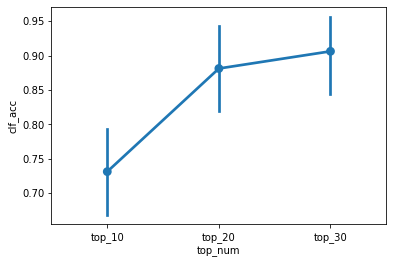

In [95]:
# write a function to extract left-out subject id and the classification acc. 
def extract_clf_acc(base_dir, top_num, num_subjs):
    
    import os
    import numpy as np
    import pandas as pd
    path = os.path.join(base_dir, top_num, 'classify_result.txt')

    # read each line, from which extract the left out subject id and the clf acc
    with open(path, "r") as file:
        lines = file.readlines()
    loo_id = []
    acc = []
    for line in lines: 
        id_start_index = line.index('_no') + len('_no')
        id_end_index = line.index('_result_seq')
        id = int(line[id_start_index:id_end_index])
        loo_id.append(id)

        acc_start_index = line.index(': ') + 2
        acc_end_index = line.index('\n')
        score = float(line[acc_start_index:acc_end_index])
        acc.append(score)

    # write a dataframe
    
    colnames = ['loo_id','clf_acc','top_num']
    df = pd.DataFrame(index=range(len(loo_id)), columns=colnames)
    df['loo_id'] = loo_id 
    df['clf_acc'] = acc
    df['top_num'] = np.repeat(top_num, len(loo_id)).tolist()
        
    return df

# generate df and concatenate them together
df_list = [extract_clf_acc(output_dir,'top_10', num_subjs),
           extract_clf_acc(output_dir,'top_20', num_subjs),
           extract_clf_acc(output_dir,'top_30', num_subjs)]
final_df = pd.concat(df_list).reset_index(drop=True)

# a quick look at the df 
ax = sns.pointplot(x="top_num", y="clf_acc", data=final_df)

## Take Aways
- Tie back our two initial questions: we asked 
    1. Do functional connectivity patterns differ across condition A and B 
    2. What are the brain regions among which the FC pattern characterize each task condition? 
- Answering Q1: 
    - Based on the scatter plot above, we can argue the functional connectivity pattern of the top n performed features can be used to differentiate whether a subject is doing condition A or B. Thus, the answer to question 1 is yes, the FC patterns do differ across condition A and B.
- Answering Q2:
    - Let's take n = 30 as an example. Remember that the top 30 features for each training sets may be different given that we have 8 trainig sets (one for each left out subject). Thus a given voxel may appear 0 - 8 times in these 8 top-30-feature masks, resulting a stats map. (i.e., 'prop_top30.nii.gz')
    - Let's look at out cherry picked brain again, which is consist of 400 voxels in total. 

The 400 voxel brain


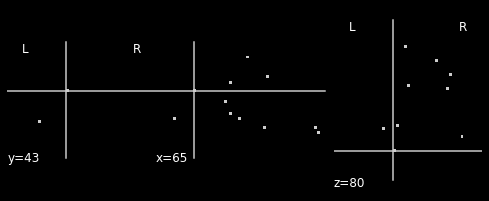

In [87]:
print("The 400 voxel brain")
plotting.plot_epi(image.load_img(os.path.join(cur_dir,'cherry_picked_brain','cherry_pick_brain_mask.nii.gz')),(65,43,80))

- Then we overlap the top-30 feature stats map onto it and observe where they locate. Note that these features may not be meaningful in this simulated dataset, but will be in a real data set. 


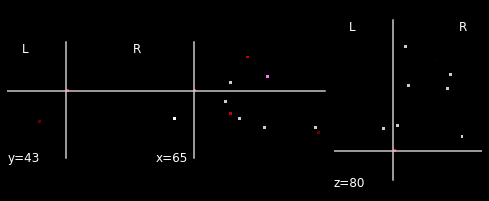

In [88]:
display = plotting.plot_epi(image.load_img(os.path.join(cur_dir,'cherry_picked_brain','cherry_pick_brain_mask.nii.gz')),cut_coords = (65,43,80))
display.add_overlay(image.load_img(os.path.join(output_dir, 'top_30','prop_top30.nii.gz')), cmap=plotting.cm.black_pink)